ID: V01076579  
Name: Charina Regis

In [ ]:
# https://drive.google.com/file/d/11_JuRTeKqqHU65kiLubEFZLpBoKkET-N/view?usp=drive_link
# Replace 'FILE_ID' with the actual ID of your file
file_id = '11_JuRTeKqqHU65kiLubEFZLpBoKkET-N'  # Replace with your file ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('survey_results_public.csv')  # Download the file locally with the same or new name

# https://drive.google.com/file/d/1qCszbklO_uWgfUrZx9fPr3T3OT2pElY3/view?usp=drive_link
# Replace 'FILE_ID' with the actual ID of your file
file_id = '1qCszbklO_uWgfUrZx9fPr3T3OT2pElY3'  # Replace with your file ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('cost-of-living_v2.csv')  # Download the file locally with the same or new name

# https://drive.google.com/file/d/1m_p2k_nZgHxuZdnk78X4r551OgNkm1zU/view?usp=drive_link
# Replace 'FILE_ID' with the actual ID of your file
file_id = '1m_p2k_nZgHxuZdnk78X4r551OgNkm1zU'  # Replace with your file ID
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('cost-of-living.csv')  # Download the file locally with the same or new name

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Load the dataset (update the filename if needed)
df = pd.read_csv("survey_results_public.csv")  # replace with the correct path if needed

# Basic shape and preview
print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (65437, 114)

Column names:
 ['ResponseId', 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'Check', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline', 'TechDoc', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'PurchaseInfluence', 'BuyNewTool', 'BuildvsBuy', 'TechEndorse', 'Country', 'Currency', 'CompTotal', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'LanguageAdmired', 'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'DatabaseAdmired', 'PlatformHaveWorkedWith', 'PlatformWantToWorkWith', 'PlatformAdmired', 'WebframeHaveWorkedWith', 'WebframeWantToWorkWith', 'WebframeAdmired', 'EmbeddedHaveWorkedWith', 'EmbeddedWantToWorkWith', 'EmbeddedAdmired', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith', 'MiscTechAdmired', 'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'ToolsTechAdmired', 'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith', 'NEWCollabToolsAdmired', 'OpSysPersonal use', 'OpSysProfessional use', 'OfficeStackAsyncHaveWo

In [ ]:
# Get all columns with missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Convert to DataFrame for better viewing
missing_df = missing.reset_index()
missing_df.columns = ['Column', 'MissingCount']

# Show all rows
pd.set_option('display.max_rows', None)

# Display
print(missing_df)

                             Column  MissingCount
0        AINextMuch less integrated         64289
1             AINextLess integrated         63082
2                   AINextNo change         52939
3        AINextMuch more integrated         51999
4                   EmbeddedAdmired         48704
5            EmbeddedWantToWorkWith         47837
6            EmbeddedHaveWorkedWith         43223
7               ConvertedCompYearly         42002
8     AIToolNot interested in Using         41023
9             AINextMore integrated         41009
10                      Knowledge_9         37802
11                      Frequency_3         37727
12                      Knowledge_8         37679
13                 ProfessionalTech         37673
14                      Knowledge_7         37659
15                      Knowledge_6         37573
16                      Knowledge_5         37557
17                      Knowledge_2         37416
18                      Knowledge_4         37407


In [ ]:
# Data types of each column
print("\nData types:")
print(df.dtypes)


Data types:
ResponseId                          int64
MainBranch                         object
Age                                object
Employment                         object
RemoteWork                         object
Check                              object
CodingActivities                   object
EdLevel                            object
LearnCode                          object
LearnCodeOnline                    object
TechDoc                            object
YearsCode                          object
YearsCodePro                       object
DevType                            object
OrgSize                            object
PurchaseInfluence                  object
BuyNewTool                         object
BuildvsBuy                         object
TechEndorse                        object
Country                            object
Currency                           object
CompTotal                         float64
LanguageHaveWorkedWith             object
LanguageWantToWorkWit

In [ ]:
# Display a few rows where both CompTotal and ConvertedCompYearly are non-null
sample_salary_compare = df[['CompTotal', 'ConvertedCompYearly']].dropna().head(10)
print(sample_salary_compare)

     CompTotal  ConvertedCompYearly
72   2040000.0               7322.0
374    28000.0              30074.0
379    85000.0              91295.0
385    50000.0              53703.0
389   110000.0             110000.0
392   126420.0             161044.0
395    95000.0             121018.0
398   195000.0             195000.0
403    35000.0              44586.0
409    54000.0              57999.0


In [ ]:
# Select Columns
keep_cols = [
    'YearsCodePro',
    'Age',
    'WorkExp',
    'ConvertedCompYearly',
    'DevType',
    'Country',
    'RemoteWork',
    'EdLevel',
    'Employment',
    'OrgSize',
    'LanguageHaveWorkedWith'
#   'DatabaseHaveWorkedWith',
#   'PlatformHaveWorkedWith',
#   'WebframeHaveWorkedWith',
#   'ToolsTechHaveWorkedWith'
]

# Filter the dataset
df_model = df[keep_cols].copy()

# Check the shape and preview
print("Model Dataset Shape:", df_model.shape)
print(df_model.head())

Model Dataset Shape: (65437, 11)
  YearsCodePro                 Age  WorkExp  ConvertedCompYearly  \
0          NaN  Under 18 years old      NaN                  NaN   
1           17     35-44 years old     17.0                  NaN   
2           27     45-54 years old      NaN                  NaN   
3          NaN     18-24 years old      NaN                  NaN   
4          NaN     18-24 years old      NaN                  NaN   

                 DevType                                            Country  \
0                    NaN                           United States of America   
1  Developer, full-stack  United Kingdom of Great Britain and Northern I...   
2   Developer Experience  United Kingdom of Great Britain and Northern I...   
3  Developer, full-stack                                             Canada   
4  Developer, full-stack                                             Norway   

  RemoteWork                                            EdLevel  \
0     Remote    

In [ ]:
print(df_model['Country'].value_counts().sort_index())

Country
Afghanistan                                                56
Albania                                                    49
Algeria                                                    77
Andorra                                                    15
Angola                                                     20
Antigua and Barbuda                                         5
Argentina                                                 345
Armenia                                                    58
Australia                                                1260
Austria                                                   791
Azerbaijan                                                 27
Bahamas                                                     4
Bahrain                                                    11
Bangladesh                                                327
Barbados                                                    6
Belarus                                                    97


In [ ]:
# Add new column Region to group the countries together
region_map = {
    'North America': ['United States of America', 'Canada', 'Mexico'],
    'South America': ['Brazil', 'Argentina', 'Chile', 'Colombia', 'Peru', 'Uruguay', 'Venezuela, Bolivarian Republic of...', 'Ecuador', 'Paraguay', 'Bolivia'],
    'Europe': [
        'Germany', 'France', 'United Kingdom of Great Britain and Northern Ireland', 'Italy', 'Spain', 'Netherlands', 'Sweden', 'Switzerland', 'Poland',
        'Portugal', 'Austria', 'Belgium', 'Ireland', 'Finland', 'Denmark', 'Norway', 'Czech Republic', 'Romania', 'Hungary', 'Greece', 'Ukraine', 'Russia',
        'Slovakia', 'Slovenia', 'Lithuania', 'Latvia', 'Estonia', 'Croatia', 'Serbia', 'Bulgaria', 'Bosnia and Herzegovina', 'Georgia', 'Moldova', 'Belarus',
        'North Macedonia', 'Luxembourg', 'Iceland', 'Malta', 'Monaco', 'Liechtenstein', 'Andorra', 'San Marino', 'Kosovo', 'Albania'
    ],
    'Asia': [
        'India', 'China', 'Japan', 'Indonesia', 'Pakistan', 'Bangladesh', 'Philippines', 'Vietnam', 'South Korea', 'Republic of Korea',
        'Thailand', 'Malaysia', 'Singapore', 'Taiwan', 'Sri Lanka', 'Nepal', 'Myanmar', 'Kazakhstan', 'Uzbekistan', 'Iran, Islamic Republic of...',
        'Iraq', 'Israel', 'Saudi Arabia', 'Turkey', 'Qatar', 'Jordan', 'United Arab Emirates', 'Kuwait', 'Lebanon', 'Oman', 'Palestine', 'Afghanistan',
        'Armenia', 'Azerbaijan', 'Yemen', 'Georgia', 'Bahrain', 'Tajikistan', 'Turkmenistan', 'Kyrgyzstan', 'Mongolia', 'Bhutan', 'Democratic People\'s Republic of Korea',
        'North Korea', 'Brunei Darussalam', 'Cambodia', 'Lao People\'s Democratic Republic', 'Syrian Arab Republic'
    ],
    'Africa': [
        'Nigeria', 'Egypt', 'South Africa', 'Kenya', 'Morocco', 'Ethiopia', 'Ghana', 'Uganda', 'Algeria', 'Tunisia', 'Sudan', 'Zambia', 'Zimbabwe',
        'Angola', 'Senegal', 'Cameroon', 'Côte d\'Ivoire', 'Rwanda', 'Tanzania', 'Libyan Arab Jamahiriya', 'Botswana', 'Namibia', 'Mozambique',
        'Madagascar', 'Malawi', 'Mali', 'Burkina Faso', 'Niger', 'Benin', 'Togo', 'Lesotho', 'Liberia', 'Guinea', 'Guinea-Bissau', 'Chad',
        'Somalia', 'Sierra Leone', 'Burundi', 'Gabon', 'Equatorial Guinea', 'Congo, Republic of the...', 'Democratic Republic of the Congo',
        'Central African Republic', 'Djibouti'
    ],
    'Oceania': [
        'Australia', 'New Zealand', 'Fiji', 'Papua New Guinea', 'Samoa', 'Micronesia, Federated States of...', 'Solomon Islands', 'Nauru'
    ],
    'Caribbean': [
        'Dominican Republic', 'Cuba', 'Haiti', 'Jamaica', 'Trinidad and Tobago', 'Barbados', 'Bahamas', 'Saint Kitts and Nevis', 'Dominica', 'Antigua and Barbuda'
    ],
    'Other': [
        'Nomadic', 'Isle of Man', 'Palestine', 'Mauritius', 'Mauritania', 'Cape Verde'
    ]
}


def assign_region(country):
    for region, countries in region_map.items():
        if country in countries:
            return region
    return 'Other'

df_model['CountryGroup'] = df_model['Country'].apply(assign_region)


CountryGroup
Europe           27634
North America    13601
Asia              9871
Other             8346
South America     2433
Africa            1780
Oceania           1665
Caribbean          107
Name: count, dtype: int64
                                                 Country   CountryGroup
1240                                         Afghanistan           Asia
404                                              Albania         Europe
62                                               Algeria         Africa
7068                                             Andorra         Europe
3369                                              Angola         Africa
21745                                Antigua and Barbuda      Caribbean
137                                            Argentina  South America
1666                                             Armenia           Asia
30                                             Australia        Oceania
36                                               Austria 

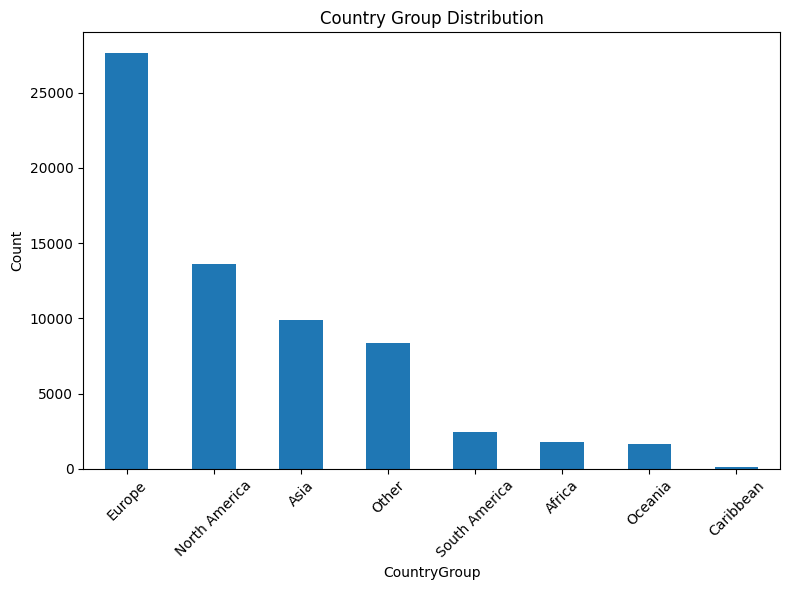

In [ ]:
print(df_model['CountryGroup'].value_counts())

# View mapping per country
print(df_model[['Country', 'CountryGroup']].drop_duplicates().sort_values('Country'))

# Plot by CountryGroup
df_model['CountryGroup'].value_counts().plot(kind='bar', figsize=(8,6))
plt.title("Country Group Distribution")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Convert Age
age_map = {
    '18-24 years old': 21,
    '25-34 years old': 29.5,
    '35-44 years old': 39.5,
    '45-54 years old': 49.5,
    '55-64 years old': 59.5
}
df_model['Age'] = df_model['Age'].map(age_map)


In [ ]:
# Convert YearsCodePro and WorkExp to numeric
df_model['YearsCodePro'] = pd.to_numeric(df_model['YearsCodePro'].replace({
    'Less than 1 year': 0.5,
    'More than 50 years': 51
}), errors='coerce')

df_model['WorkExp'] = pd.to_numeric(df_model['WorkExp'], errors='coerce')

# Convert salary target
df_model['ConvertedCompYearly'] = pd.to_numeric(df_model['ConvertedCompYearly'], errors='coerce')

# Drop rows where salary is missing or zero
df_model = df_model[df_model['ConvertedCompYearly'].notna() & (df_model['ConvertedCompYearly'] > 1000)]


In [ ]:
# Add new column ExperienceLevel based on WorkExp
def map_experience_level(years):
    if pd.isna(years):
        return np.nan
    elif years < 2:
        return 'Beginner'
    elif years < 5:
        return 'Intermediate'
    elif years < 10:
        return 'Advanced'
    else:
        return 'Expert'

df_model['ExperienceLevel'] = df_model['YearsCodePro'].apply(map_experience_level)


/tmp/ipython-input-584-1468868940.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['ExperienceLevel'] = df_model['YearsCodePro'].apply(map_experience_level)


In [ ]:
# Check the shape and preview
print("Model Dataset Shape:", df_model.shape)
print(df_model.head())

Model Dataset Shape: (22888, 13)
     YearsCodePro   Age  WorkExp  ConvertedCompYearly  \
72            1.0  21.0      3.0               7322.0   
374           6.0  29.5      NaN              30074.0   
379           6.0  39.5      7.0              91295.0   
385          17.0  39.5      NaN              53703.0   
389           7.0  29.5      8.0             110000.0   

                                           DevType                   Country  \
72   Data scientist or machine learning specialist                  Pakistan   
374                            Academic researcher                   Austria   
379  Data scientist or machine learning specialist                    Turkey   
385                            Developer, back-end                    France   
389                                        Student  United States of America   

                               RemoteWork  \
72   Hybrid (some remote, some in-person)   
374  Hybrid (some remote, some in-person)   
379     

In [ ]:
# Drop rows with missing values in key numeric fields
df_model = df_model.dropna(subset=['YearsCodePro', 'WorkExp', 'ConvertedCompYearly', 'Age', 'ExperienceLevel'])

# Confirm shape
print("Model Dataset Shape:", df_model.shape)

Model Dataset Shape: (15705, 13)


In [ ]:
# Basic stats for numeric columns
print("\nSummary statistics for numerical features:")
print(df_model.describe())


Summary statistics for numerical features:
       YearsCodePro           Age       WorkExp  ConvertedCompYearly
count  15705.000000  15705.000000  15705.000000         1.570500e+04
mean      10.024610     33.900032     11.102706         8.763932e+04
std        8.017344      9.145362      8.666088         1.735642e+05
min        0.500000     21.000000      0.000000         1.005000e+03
25%        4.000000     29.500000      5.000000         3.636500e+04
50%        8.000000     29.500000      9.000000         6.766600e+04
75%       14.000000     39.500000     15.000000         1.100000e+05
max       51.000000     59.500000     50.000000         1.381802e+07


In [ ]:
# Data types of each column
print("\nData types:")
print(df_model.dtypes)


Data types:
YearsCodePro              float64
Age                       float64
WorkExp                   float64
ConvertedCompYearly       float64
DevType                    object
Country                    object
RemoteWork                 object
EdLevel                    object
Employment                 object
OrgSize                    object
LanguageHaveWorkedWith     object
CountryGroup               object
ExperienceLevel            object
dtype: object


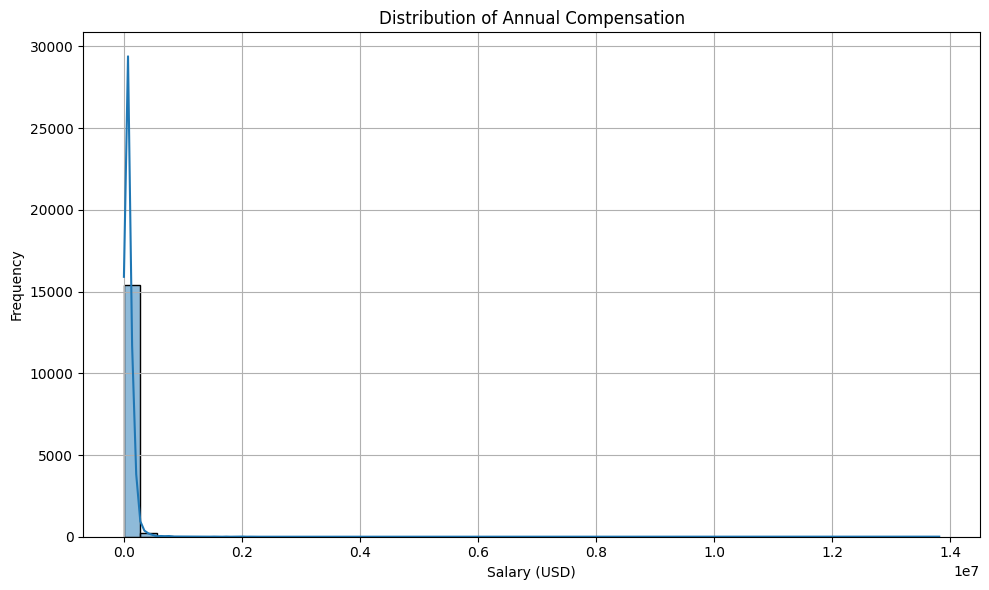

In [ ]:
# Set figure size and style
plt.figure(figsize=(10, 6))
sns.histplot(df_model['ConvertedCompYearly'], bins=50, kde=True)

plt.title('Distribution of Annual Compensation')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


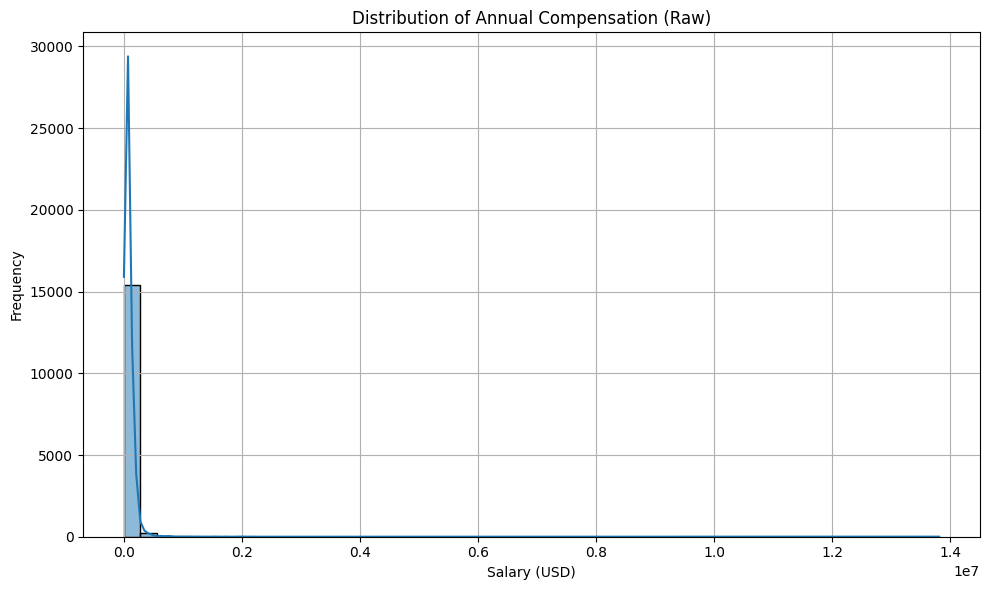

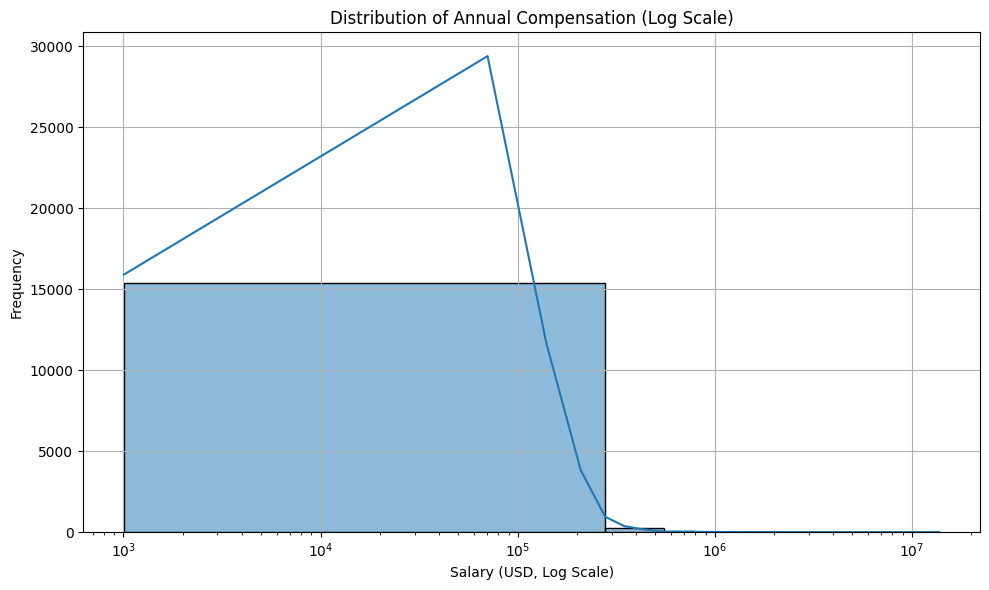

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_model['ConvertedCompYearly'], bins=50, kde=True)

plt.title('Distribution of Annual Compensation (Raw)')
plt.xlabel('Salary (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: log-scale
plt.figure(figsize=(10, 6))
sns.histplot(df_model['ConvertedCompYearly'], bins=50, kde=True)
plt.xscale('log')
plt.title('Distribution of Annual Compensation (Log Scale)')
plt.xlabel('Salary (USD, Log Scale)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Add log-transformed salary column (base 10)
df_model['LogSalary'] = np.log10(df_model['ConvertedCompYearly'])

# Drop rows where log10 gave -inf (i.e., salary <= 0)
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna(subset=['LogSalary'])


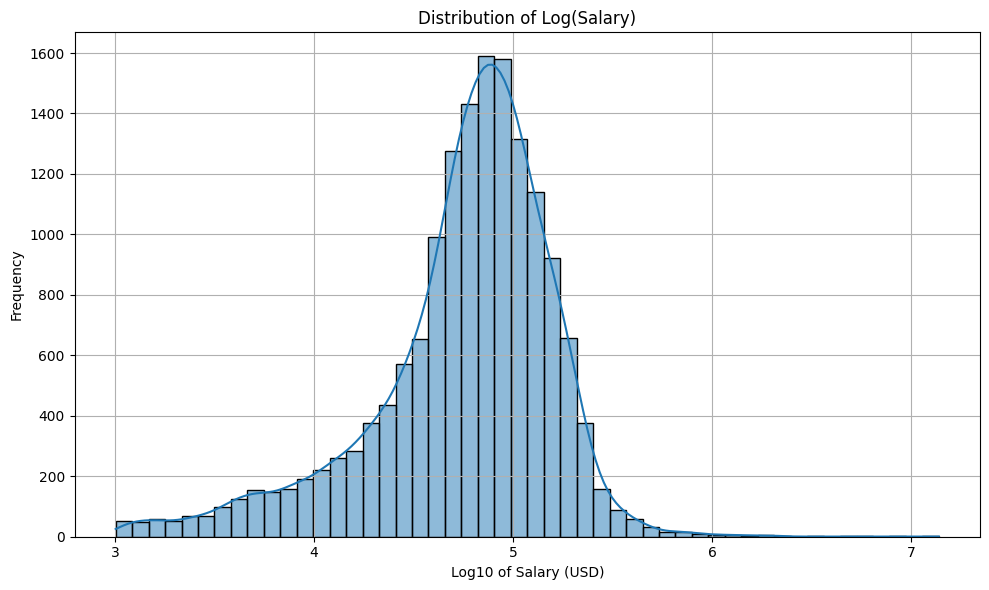

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_model['LogSalary'], bins=50, kde=True)
plt.title('Distribution of Log(Salary)')
plt.xlabel('Log10 of Salary (USD)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install wbgapi
!pip install pycountry


In [ ]:
import wbgapi as wb

# Fetch GDP per capita via wbgapi (most recent year)
wb_series = 'NY.GDP.PCAP.CD'
gdp_data = wb.data.DataFrame(wb_series, time=2024, labels=True)
gdp_data = gdp_data.reset_index()[['economy', wb_series]]
gdp_data.columns = ['Country', 'GDP_per_capita']

print(gdp_data.head())


  Country  GDP_per_capita
0     ZWE     2656.409377
1     ZMB     1235.084665
2     YEM      433.174015
3     PSE     2592.305912
4     VIR             NaN


In [ ]:
import pycountry

# Function to convert 3-letter ISO codes to full country names
def iso3_to_country_name(iso3):
    try:
        return pycountry.countries.get(alpha_3=iso3).name
    except:
        return None

# Apply conversion
gdp_data['Country'] = gdp_data['Country'].apply(iso3_to_country_name)

# Drop entries where mapping failed
gdp_data = gdp_data.dropna(subset=['Country'])

# Preview cleaned GDP data
print(gdp_data.head())


                Country  GDP_per_capita
0              Zimbabwe     2656.409377
1                Zambia     1235.084665
2                 Yemen      433.174015
3   Palestine, State of     2592.305912
4  Virgin Islands, U.S.             NaN


In [ ]:
# List countries where GDP_per_capita is NaN
missing_gdp_countries = gdp_data[gdp_data['GDP_per_capita'].isna()]['Country'].unique()

# Display the list
print("Countries with missing GDP data:")
print(missing_gdp_countries)


Countries with missing GDP data:
['Virgin Islands, U.S.' 'Venezuela, Bolivarian Republic of' 'Tuvalu'
 'Tonga' 'Syrian Arab Republic' 'Saint Martin (French part)' 'South Sudan'
 'San Marino' 'Palau' 'Northern Mariana Islands' 'New Caledonia' 'Monaco'
 'Liechtenstein' 'Lebanon' 'Korea, Republic of'
 "Korea, Democratic People's Republic of" 'Isle of Man' 'Guam' 'Greenland'
 'Gibraltar' 'French Polynesia' 'Faroe Islands' 'Ethiopia' 'Eritrea'
 'Curaçao' 'Cuba' 'Cayman Islands' 'Virgin Islands, British' 'Bhutan'
 'Aruba' 'American Samoa' 'Afghanistan']


In [ ]:
gdp_fill = {
    'Korea, Republic of': 34667,
    'Ethiopia': 1041,
    'Cuba': 9645,
    'Lebanon': 5796,
    'South Sudan': 274,
    'Monaco': 173688,
    'Afghanistan': 378,
    'Bhutan': 3595,
    'Tuvalu': 4334,
    'Tonga': 5119,
    'Palau': 11963,
    'San Marino': 53284,
    'Liechtenstein': 180000,
    'Greenland': 48588,
    'Gibraltar': 92871,
    'Faroe Islands': 56846,
    'Isle of Man': 88760,
    'Guam': 35379,
    'Virgin Islands, U.S.': 36000,
    'Virgin Islands, British': 32000,
    'Aruba': 29800,
    'American Samoa': 11651,
    'Northern Mariana Islands': 21515,
    'New Caledonia': 36125,
    'French Polynesia': 24000,
    'Saint Martin (French part)': 39400,
    "Korea, Democratic People's Republic of": 600,
    'Cayman Islands': 91000,
    'Curaçao': 25710,
    'Venezuela, Bolivarian Republic of': 1580,
    'Eritrea': 610,
    'Syrian Arab Republic': 870,
}

gdp_data['GDP_per_capita'] = gdp_data.apply(
    lambda row: gdp_fill.get(row['Country'], row['GDP_per_capita']),
    axis=1
)


In [ ]:
print("Still missing GDP values:", gdp_data['GDP_per_capita'].isna().sum())


Still missing GDP values: 0


In [ ]:
# View sorted unique country names in the GDP dataset
print(sorted(gdp_data['Country'].unique()))


['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia, Plurinational State of', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Congo, The Democratic Republic of the', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Gr

In [ ]:
country_name_fix = {
    'United States of America': 'United States',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Czech Republic': 'Czechia',
    'Iran, Islamic Republic of...': 'Iran, Islamic Republic of',
    'Venezuela, Bolivarian Republic of...': 'Venezuela, Bolivarian Republic of',
    'South Korea': 'Korea, Republic of',
    'Republic of Korea': 'Korea, Republic of',
    'Hong Kong (S.A.R.)': 'Hong Kong',
    'Palestine': 'Palestine, State of',
    'Democratic Republic of the Congo': 'Congo, The Democratic Republic of the',
    'Republic of North Macedonia': 'North Macedonia',
    'Democratic People\'s Republic of Korea': "Korea, Democratic People's Republic of",
    'Republic of Moldova': 'Moldova',
    'Libyan Arab Jamahiriya': 'Libya',
    'United Republic of Tanzania': 'Tanzania',
    'Congo, Republic of the...': 'Congo',
    'Cape Verde': 'Cabo Verde',
    'Kosovo': 'Kosovo',
    'Taiwan': 'Taiwan',
    'Turkey': 'Türkiye',
    'Bolivia': 'Bolivia, Plurinational State of',
    'Korea, Dem. People’s Rep.': "Korea, Democratic People's Republic of",
    'Moldova': 'Moldova, Republic of',
    'Tanzania': 'Tanzania, United Republic of',
    'Nomadic': None  # Drop if not a real country
}

# Fix country names in df_model using mapping
df_model['Country'] = df_model['Country'].replace(country_name_fix)


In [ ]:
# Merge GDP per capita into your salary dataset
df_model = df_model.merge(gdp_data, on='Country', how='left')


In [ ]:
print(df_model.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'DevType', 'Country', 'RemoteWork', 'EdLevel', 'Employment', 'OrgSize', 'LanguageHaveWorkedWith', 'CountryGroup', 'ExperienceLevel', 'LogSalary', 'GDP_per_capita']


In [ ]:
missing_gdp_rows = df_model[df_model['GDP_per_capita'].isna()]
print("Number of rows with missing GDP:", len(missing_gdp_rows))
print(missing_gdp_rows[['Country']].drop_duplicates())  # optional

Number of rows with missing GDP: 84
        Country
1085     Taiwan
2926    Moldova
3953     Kosovo
7903   Tanzania
14794      None


In [ ]:
manual_gdp = {
    'Taiwan': 32800,     # estimated
    'Kosovo': 4600,      # estimated
    'Moldova': 6200,     # double-check if missing
    'Tanzania': 1200     # backup value
}

df_model['GDP_per_capita'] = df_model.apply(
    lambda row: manual_gdp[row['Country']] if pd.isna(row['GDP_per_capita']) and row['Country'] in manual_gdp else row['GDP_per_capita'],
    axis=1
)


In [ ]:
missing_gdp_rows = df_model[df_model['GDP_per_capita'].isna()]
print("Number of rows with missing GDP:", len(missing_gdp_rows))
print(missing_gdp_rows[['Country']].drop_duplicates())  # optional

Number of rows with missing GDP: 1
      Country
14794    None


In [ ]:
print(df_model.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'DevType', 'Country', 'RemoteWork', 'EdLevel', 'Employment', 'OrgSize', 'LanguageHaveWorkedWith', 'CountryGroup', 'ExperienceLevel', 'LogSalary', 'GDP_per_capita']


In [ ]:
df_model.shape

(15705, 15)

In [ ]:
df_model = df_model[df_model['GDP_per_capita'].notna()]

In [ ]:
df_model.shape

(15704, 15)

In [ ]:
print(df_model.head())

   YearsCodePro   Age  WorkExp  ConvertedCompYearly  \
0           1.0  21.0      3.0               7322.0   
1           6.0  39.5      7.0              91295.0   
2           7.0  29.5      8.0             110000.0   
3          18.0  39.5     18.0             161044.0   
4          30.0  49.5     30.0             195000.0   

                                         DevType         Country  \
0  Data scientist or machine learning specialist        Pakistan   
1  Data scientist or machine learning specialist         Türkiye   
2                                        Student   United States   
3                            Engineering manager  United Kingdom   
4                          Developer, full-stack   United States   

                             RemoteWork  \
0  Hybrid (some remote, some in-person)   
1                                Remote   
2                                Remote   
3  Hybrid (some remote, some in-person)   
4                                Remote   

 

In [ ]:
import pandas as pd

# Load the cost of living dataset
cost_df = pd.read_csv('cost-of-living_v2.csv')

# Group by country and compute the mean cost index per country
cost_df_summary = (
    cost_df
    .groupby('country')['x2']
    .mean()
    .reset_index()
    .rename(columns={'country': 'Country', 'x2': 'Cost_Index'})
)

# Now list the unique countries
unique_cost_countries = sorted(cost_df_summary['Country'].dropna().unique())
print(unique_cost_countries)


['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia And Herzegovina', 'Botswana', 'Brazil', 'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica', 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Ethiopia', 'Falkland Islands', 'Faroe Islands', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland', 'Guadeloupe', 'Guatemala', 'Guinea', 'Guine

In [ ]:
print(sorted(df_model['Country'].unique()))

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia, Plurinational State of', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Congo', 'Congo, The Democratic Republic of the', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', "Côte d'Ivoire", 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran, Islamic Republic of', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', "Korea, Democratic People's Republic of", 'Korea, Republic of', 'Kosovo', 'Kuwait', 'Kyrgyzstan', "Lao People's Democratic R

In [ ]:
cost_index_country_mapping = {
    'Bolivia': 'Bolivia, Plurinational State of',
    'Bosnia And Herzegovina': 'Bosnia and Herzegovina',
    'Cape Verde': 'Cabo Verde',
    'Congo': 'Congo, The Democratic Republic of the',
    'Czech Republic': 'Czechia',
    'Ivory Coast': "Côte d'Ivoire",
    'Iran': 'Iran, Islamic Republic of',
    'Isle Of Man': 'Isle of Man',
    'North Korea': "Korea, Democratic People's Republic of",
    'South Korea': 'Korea, Republic of',
    'Kosovo (Disputed Territory)': 'Kosovo',
    'Laos': "Lao People's Democratic Republic",
    'Palestine': 'Palestine, State of',
    'Russia': 'Russian Federation',
    'Syria': 'Syrian Arab Republic',
    'Trinidad And Tobago': 'Trinidad and Tobago',
    'Turkey': 'Türkiye',
    'Venezuela': 'Venezuela, Bolivarian Republic of',
    'Vietnam': 'Viet Nam'
}

# Rename country names in cost_df_summary to match df_model
cost_df_summary['Country'] = cost_df_summary['Country'].replace(cost_index_country_mapping)


In [ ]:
df_model = df_model.merge(cost_df_summary, on='Country', how='left')


In [ ]:
print(df_model.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'DevType', 'Country', 'RemoteWork', 'EdLevel', 'Employment', 'OrgSize', 'LanguageHaveWorkedWith', 'CountryGroup', 'ExperienceLevel', 'LogSalary', 'GDP_per_capita', 'Cost_Index']


In [ ]:
# Check for missing values in the Cost_Index column
missing_cost_index = df_model[df_model['Cost_Index'].isna()]

# Print how many rows are missing Cost Index
print("Number of rows with missing Cost_Index:", len(missing_cost_index))

# Print the unique countries that have missing Cost Index values
print("Countries with missing Cost_Index:")
print(missing_cost_index['Country'].dropna().unique())


Number of rows with missing Cost_Index: 6
Countries with missing Cost_Index:
['Palestine, State of' 'Congo']


In [ ]:
# Fill missing Cost_Index with reasonable estimates
manual_cost_index = {
    'Palestine, State of': 35.0,  # rough estimate based on nearby countries
    'Congo': 30.0                 # general estimate for lower-cost regions
}

df_model['Cost_Index'] = df_model.apply(
    lambda row: manual_cost_index.get(row['Country'], row['Cost_Index']),
    axis=1
)


In [ ]:
# Check for any remaining missing Cost_Index values
missing_cost_index = df_model[df_model['Cost_Index'].isna()]

# Display the count and any remaining countries
print("Remaining rows with missing Cost_Index:", len(missing_cost_index))
print("Countries still missing:", missing_cost_index['Country'].dropna().unique())


Remaining rows with missing Cost_Index: 0
Countries still missing: []


In [ ]:
# Calculate adjusted salary (normalized for cost of living)
df_model['Adj_Salary'] = df_model['ConvertedCompYearly'] / df_model['Cost_Index']

# Log-transform for model target
df_model['LogAdjSalary'] = np.log10(df_model['Adj_Salary'])

# Preview result
print(df_model[['Country', 'ConvertedCompYearly', 'Cost_Index', 'Adj_Salary', 'LogAdjSalary']].head())


          Country  ConvertedCompYearly  Cost_Index   Adj_Salary  LogAdjSalary
0        Pakistan               7322.0   10.299143   710.932949      2.851829
1         Türkiye              91295.0   13.506102  6759.537434      3.829917
2   United States             110000.0   62.048253  1772.813815      3.248663
3  United Kingdom             161044.0   64.380714  2501.432328      3.398189
4   United States             195000.0   62.048253  3142.715399      3.497305


In [ ]:
print(df_model.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'DevType', 'Country', 'RemoteWork', 'EdLevel', 'Employment', 'OrgSize', 'LanguageHaveWorkedWith', 'CountryGroup', 'ExperienceLevel', 'LogSalary', 'GDP_per_capita', 'Cost_Index', 'Adj_Salary', 'LogAdjSalary']


In [ ]:
# List of categorical columns to encode
cat_columns = ['EdLevel', 'RemoteWork', 'OrgSize', 'ExperienceLevel', 'Country', 'CountryGroup']

# One-hot encode them and drop original columns
df_encoded = pd.get_dummies(df_model, columns=cat_columns, drop_first=True, dtype=int)

# Preview new shape and columns
print("Encoded Dataset Shape:", df_encoded.shape)
print("Example of new columns:", df_encoded.columns.tolist())

Encoded Dataset Shape: (15704, 189)
Example of new columns: ['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'DevType', 'Employment', 'LanguageHaveWorkedWith', 'LogSalary', 'GDP_per_capita', 'Cost_Index', 'Adj_Salary', 'LogAdjSalary', 'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'EdLevel_Primary/elementary school', 'EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)', 'EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 'EdLevel_Some college/university study without earning a degree', 'EdLevel_Something else', 'RemoteWork_In-person', 'RemoteWork_Remote', 'OrgSize_10 to 19 employees', 'OrgSize_10,000 or more employees', 'OrgSize_100 to 499 employees', 'OrgSize_2 to 9 employees', 'OrgSize_20 to 99 employees', 'OrgSize_5,000 to 9,999 employees', 'OrgSize_500 to 999 employees', 'OrgSize_I don’t know', 'OrgSize_Just me - I am a freelancer, sole proprietor, etc.', 'Expe

In [ ]:
df_encoded.head()

,YearsCodePro,Age,WorkExp,ConvertedCompYearly,DevType,Employment,LanguageHaveWorkedWith,LogSalary,GDP_per_capita,Cost_Index,...,Country_Yemen,Country_Zambia,Country_Zimbabwe,CountryGroup_Asia,CountryGroup_Caribbean,CountryGroup_Europe,CountryGroup_North America,CountryGroup_Oceania,CountryGroup_Other,CountryGroup_South America
0,1.0,21.0,3.0,7322.0,Data scientist or machine learning specialist,"Employed, full-time;Student, full-time;Indepen...",Assembly;Bash/Shell (all shells);C;C++;HTML/CS...,3.864630,1484.749859,10.299143,...,0,0,0,1,0,0,0,0,0,0
1,6.0,39.5,7.0,91295.0,Data scientist or machine learning specialist,"Employed, full-time",JavaScript;Julia;Python;SQL;TypeScript,4.960447,15473.287264,13.506102,...,0,0,0,1,0,0,0,0,0,0
2,7.0,29.5,8.0,110000.0,Student,"Employed, full-time;Student, part-time",HTML/CSS;JavaScript;Python;SQL;TypeScript,5.041393,85809.900385,62.048253,...,0,0,0,0,0,0,1,0,0,0
3,18.0,39.5,18.0,161044.0,Engineering manager,"Employed, full-time",C#;HTML/CSS;Java;JavaScript;MicroPython;Python...,5.206945,52636.786594,64.380714,...,0,0,0,0,0,1,0,0,0,0
4,30.0,49.5,30.0,195000.0,"Developer, full-stack","Employed, full-time",Bash/Shell (all shells);C#;HTML/CSS;JavaScript...,5.290035,85809.900385,62.048253,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Check columns with object (string) data types
non_numeric_columns = df_encoded.select_dtypes(include=['object']).columns.tolist()

# Show rows where any of those columns contain non-numeric data
for col in non_numeric_columns:
    unique_vals = df_encoded[col].dropna().unique()
    print(f"\nColumn: {col}")
    print("Sample values:", unique_vals[:5])



Column: DevType
Sample values: ['Data scientist or machine learning specialist' 'Student'
 'Engineering manager' 'Developer, full-stack' 'Developer, back-end']

Column: Employment
Sample values: ['Employed, full-time;Student, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Employed, full-time' 'Employed, full-time;Student, part-time'
 'Employed, full-time;Independent contractor, freelancer, or self-employed'
 'Independent contractor, freelancer, or self-employed']

Column: LanguageHaveWorkedWith
Sample values: ['Assembly;Bash/Shell (all shells);C;C++;HTML/CSS;Java;JavaScript;Python;R;SQL;TypeScript'
 'JavaScript;Julia;Python;SQL;TypeScript'
 'HTML/CSS;JavaScript;Python;SQL;TypeScript'
 'C#;HTML/CSS;Java;JavaScript;MicroPython;Python;TypeScript'
 'Bash/Shell (all shells);C#;HTML/CSS;JavaScript;PowerShell;SQL;TypeScript']


In [ ]:
# Multi-Hot Encode Multi-Label Columns
def multi_hot_encode(df, column, prefix):
    """
    Splits multi-label entries (semicolon-separated) and returns one-hot-encoded DataFrame.
    """
    # Split and explode
    exploded = df[[column]].dropna()
    exploded[column] = exploded[column].str.split(';')
    exploded = exploded.explode(column)

    # Create dummy columns
    dummies = pd.get_dummies(exploded[column].str.strip(), prefix=prefix)

    # Combine back to original index
    dummies.index = exploded.index
    return dummies.groupby(dummies.index).sum()

In [ ]:
for col, prefix in [
    ('DevType', 'Dev'),
    ('Employment', 'Employment'),
    ('LanguageHaveWorkedWith', 'Lang'),
#    ('DatabaseHaveWorkedWith', 'DB'),
#    ('PlatformHaveWorkedWith', 'Plat'),
#    ('WebframeHaveWorkedWith', 'Web'),
#    ('ToolsTechHaveWorkedWith', 'Tool'),
]:
    encoded = multi_hot_encode(df_encoded, col, prefix)
    df_encoded = df_encoded.join(encoded)


In [ ]:
df_encoded.head()

,YearsCodePro,Age,WorkExp,ConvertedCompYearly,DevType,Employment,LanguageHaveWorkedWith,LogSalary,GDP_per_capita,Cost_Index,...,Lang_Rust,Lang_SQL,Lang_Scala,Lang_Solidity,Lang_Swift,Lang_TypeScript,Lang_VBA,Lang_Visual Basic (.Net),Lang_Zephyr,Lang_Zig
0,1.0,21.0,3.0,7322.0,Data scientist or machine learning specialist,"Employed, full-time;Student, full-time;Indepen...",Assembly;Bash/Shell (all shells);C;C++;HTML/CS...,3.864630,1484.749859,10.299143,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6.0,39.5,7.0,91295.0,Data scientist or machine learning specialist,"Employed, full-time",JavaScript;Julia;Python;SQL;TypeScript,4.960447,15473.287264,13.506102,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,7.0,29.5,8.0,110000.0,Student,"Employed, full-time;Student, part-time",HTML/CSS;JavaScript;Python;SQL;TypeScript,5.041393,85809.900385,62.048253,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,18.0,39.5,18.0,161044.0,Engineering manager,"Employed, full-time",C#;HTML/CSS;Java;JavaScript;MicroPython;Python...,5.206945,52636.786594,64.380714,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,30.0,49.5,30.0,195000.0,"Developer, full-stack","Employed, full-time",Bash/Shell (all shells);C#;HTML/CSS;JavaScript...,5.290035,85809.900385,62.048253,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# Drop Original String Columns
drop_cols = [
    'DevType', 'Employment', 'LanguageHaveWorkedWith'
#   'DevType', 'Employment', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith',
#   'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'ToolsTechHaveWorkedWith'
]
df_encoded = df_encoded.drop(columns=drop_cols)


In [ ]:
# Group Low-Frequency Languages into “Other”
lang_cols = [col for col in df_encoded.columns if col.startswith('Lang_')]
lang_counts = df_encoded[lang_cols].sum().sort_values(ascending=False)


In [ ]:
threshold = 100
popular_langs = lang_counts[lang_counts >= threshold].index.tolist()
rare_langs = list(set(lang_cols) - set(popular_langs))
df_encoded['Lang_Other'] = df_encoded[rare_langs].sum(axis=1).clip(upper=1)


In [ ]:
df_encoded.drop(columns=rare_langs, inplace=True)


In [ ]:
df_encoded.head()

,YearsCodePro,Age,WorkExp,ConvertedCompYearly,LogSalary,GDP_per_capita,Cost_Index,Adj_Salary,LogAdjSalary,"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)",...,Lang_Rust,Lang_SQL,Lang_Scala,Lang_Solidity,Lang_Swift,Lang_TypeScript,Lang_VBA,Lang_Visual Basic (.Net),Lang_Zig,Lang_Other
0,1.0,21.0,3.0,7322.0,3.864630,1484.749859,10.299143,710.932949,2.851829,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,6.0,39.5,7.0,91295.0,4.960447,15473.287264,13.506102,6759.537434,3.829917,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,7.0,29.5,8.0,110000.0,5.041393,85809.900385,62.048253,1772.813815,3.248663,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,18.0,39.5,18.0,161044.0,5.206945,52636.786594,64.380714,2501.432328,3.398189,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,30.0,49.5,30.0,195000.0,5.290035,85809.900385,62.048253,3142.715399,3.497305,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
pd.set_option('display.max_info_columns', 500)  # or None for unlimited
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15704 entries, 0 to 15703
Data columns (total 271 columns):
 #    Column                                                                                      Non-Null Count  Dtype  
---   ------                                                                                      --------------  -----  
 0    YearsCodePro                                                                                15704 non-null  float64
 1    Age                                                                                         15704 non-null  float64
 2    WorkExp                                                                                     15704 non-null  float64
 3    ConvertedCompYearly                                                                         15704 non-null  float64
 4    LogSalary                                                                                   15704 non-null  float64
 5    GDP_per_capita                

In [ ]:
print(df_encoded.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'LogSalary', 'GDP_per_capita', 'Cost_Index', 'Adj_Salary', 'LogAdjSalary', 'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'EdLevel_Primary/elementary school', 'EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)', 'EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 'EdLevel_Some college/university study without earning a degree', 'EdLevel_Something else', 'RemoteWork_In-person', 'RemoteWork_Remote', 'OrgSize_10 to 19 employees', 'OrgSize_10,000 or more employees', 'OrgSize_100 to 499 employees', 'OrgSize_2 to 9 employees', 'OrgSize_20 to 99 employees', 'OrgSize_5,000 to 9,999 employees', 'OrgSize_500 to 999 employees', 'OrgSize_I don’t know', 'OrgSize_Just me - I am a freelancer, sole proprietor, etc.', 'ExperienceLevel_Beginner', 'ExperienceLevel_Expert', 'ExperienceLevel_Intermediate', 'Country_Albania', 'Country_Al

In [ ]:
df_encoded.isnull().sum().sort_values(ascending=False).head(10)


,0
Lang_F#,38
Lang_Fortran,38
Lang_PHP,38
Lang_Objective-C,38
Lang_GDScript,38
Lang_Go,38
Lang_Groovy,38
Lang_HTML/CSS,38
Lang_Haskell,38
Lang_Apex,38


In [ ]:
# Fill NaNs in only numeric columns (float and int) with 0
df_encoded[df_encoded.select_dtypes(include=['number']).columns] = \
    df_encoded.select_dtypes(include=['number']).fillna(0)


In [ ]:
df_encoded.isnull().sum().sort_values(ascending=False).head(10)

,0
Lang_Other,0
YearsCodePro,0
Age,0
WorkExp,0
ConvertedCompYearly,0
LogSalary,0
GDP_per_capita,0
Cost_Index,0
Adj_Salary,0
LogAdjSalary,0


In [ ]:
print("Final Encoded Dataset Shape:", df_encoded.shape)

Final Encoded Dataset Shape: (15704, 271)


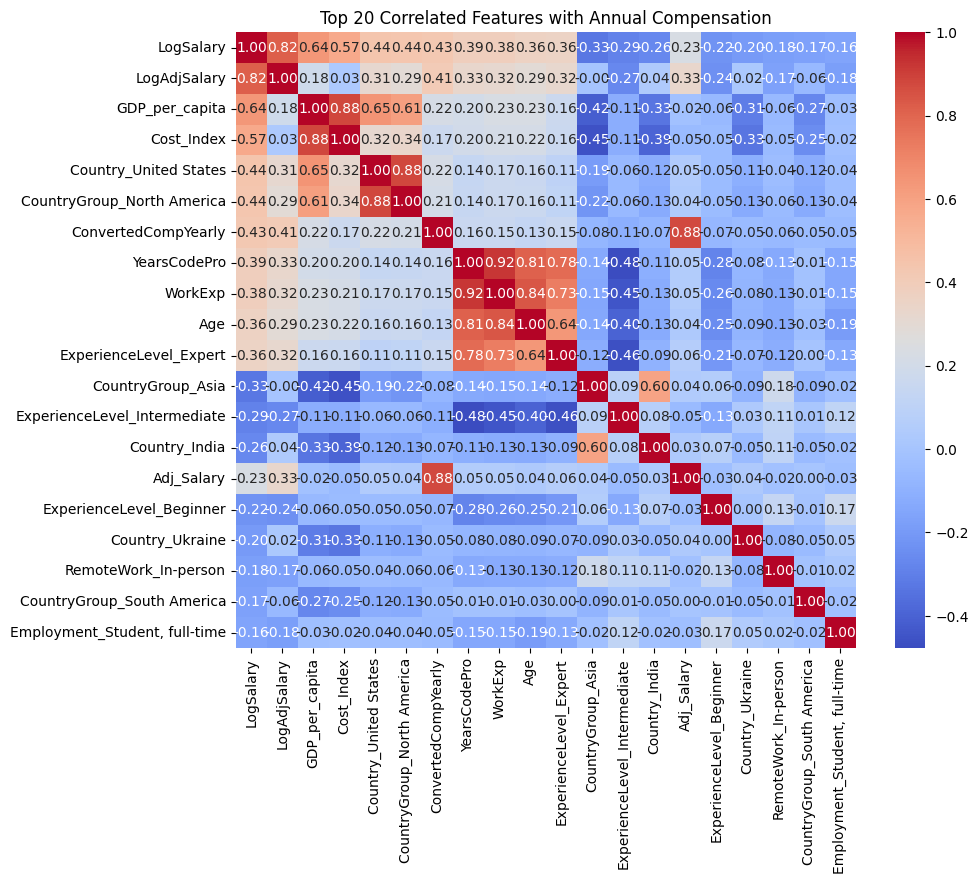

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation (only for numeric features)
corr_matrix = df_encoded.select_dtypes(include=['float64', 'int64']).corr()

# Focused plot for top correlated with salary
#top_corr = corr_matrix['ConvertedCompYearly'].abs().sort_values(ascending=False).head(20)
top_corr = corr_matrix['LogSalary'].abs().sort_values(ascending=False).head(20)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[top_corr.index].loc[top_corr.index], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top 20 Correlated Features with Annual Compensation")
plt.show()


In [ ]:
#get correlation between features
correlation_info = df_encoded.corr()

#select correlation on price_cad using absolute values and sorted
#corr_salary = correlation_info['ConvertedCompYearly']
corr_salary = correlation_info['LogSalary']

corr_sorted = corr_salary.abs().sort_values(ascending=False)

#display correlation
print("Correlation of Compensation (sorted by absolute value):")
print(corr_sorted)

Correlation of Compensation (sorted by absolute value):
LogSalary                                                                                     1.000000
LogAdjSalary                                                                                  0.819349
GDP_per_capita                                                                                0.638478
Cost_Index                                                                                    0.572583
Country_United States                                                                         0.442433
CountryGroup_North America                                                                    0.438171
ConvertedCompYearly                                                                           0.426396
YearsCodePro                                                                                  0.385490
WorkExp                                                                                       0.384383
Age              

In [ ]:
print(df_encoded.columns.tolist())

['YearsCodePro', 'Age', 'WorkExp', 'ConvertedCompYearly', 'LogSalary', 'GDP_per_capita', 'Cost_Index', 'Adj_Salary', 'LogAdjSalary', 'EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)', 'EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'EdLevel_Primary/elementary school', 'EdLevel_Professional degree (JD, MD, Ph.D, Ed.D, etc.)', 'EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)', 'EdLevel_Some college/university study without earning a degree', 'EdLevel_Something else', 'RemoteWork_In-person', 'RemoteWork_Remote', 'OrgSize_10 to 19 employees', 'OrgSize_10,000 or more employees', 'OrgSize_100 to 499 employees', 'OrgSize_2 to 9 employees', 'OrgSize_20 to 99 employees', 'OrgSize_5,000 to 9,999 employees', 'OrgSize_500 to 999 employees', 'OrgSize_I don’t know', 'OrgSize_Just me - I am a freelancer, sole proprietor, etc.', 'ExperienceLevel_Beginner', 'ExperienceLevel_Expert', 'ExperienceLevel_Intermediate', 'Country_Albania', 'Country_Al

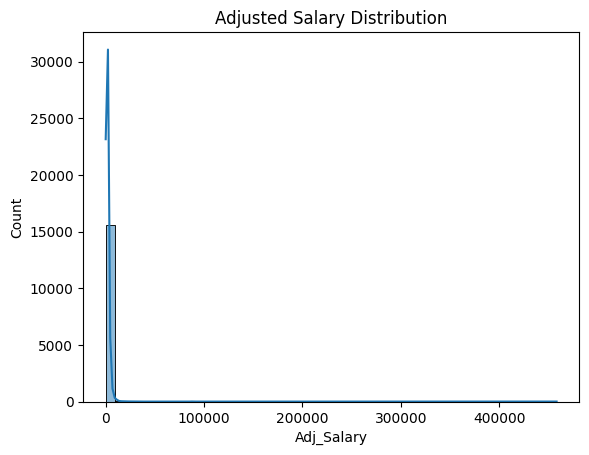

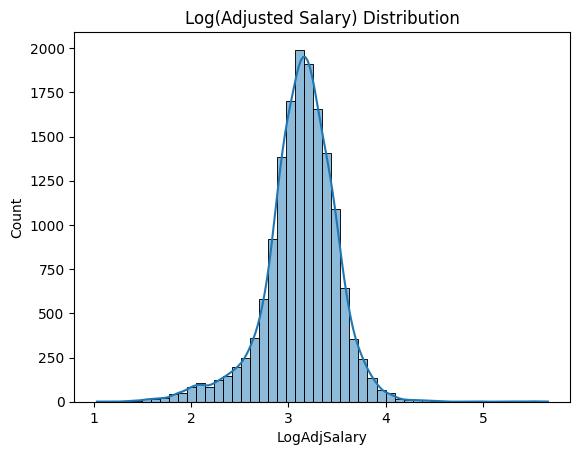

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of Adj_Salary
sns.histplot(df_encoded['Adj_Salary'], bins=50, kde=True)
plt.title("Adjusted Salary Distribution")
plt.show()

# Histogram of LogAdjSalary
sns.histplot(df_encoded['LogAdjSalary'], bins=50, kde=True)
plt.title("Log(Adjusted Salary) Distribution")
plt.show()


# Split

In [ ]:
# ------------------------------------
# Define features and target
# ------------------------------------
#X = df_encoded.drop(columns=['ConvertedCompYearly', 'LogSalary'])  # Drop target and redundant
#y = df_encoded['LogSalary']  # Target is log10-transformed salary

X = df_encoded.drop(columns=['ConvertedCompYearly', 'LogSalary', 'Adj_Salary', 'LogAdjSalary']) # Drop target and redundant
y = df_encoded['LogSalary']   # Target is log10-transformed salary

# ------------------------------------
# Check for zero-variance columns (columns with all 0s)
# ------------------------------------
zero_var_cols = X.columns[(X.nunique() <= 1)]
X = X.drop(columns=zero_var_cols)
print(f"Final feature set shape: {X.shape}")

# ------------------------------------
# Train/test split
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Final feature set shape: (15704, 267)
Train shape: (12563, 267), Test shape: (3141, 267)


# Linear Regression

Train RMSE: 0.2798
Train R²: 0.6335
Linear Regression RMSE: 0.28
Linear Regression R²: 0.6093


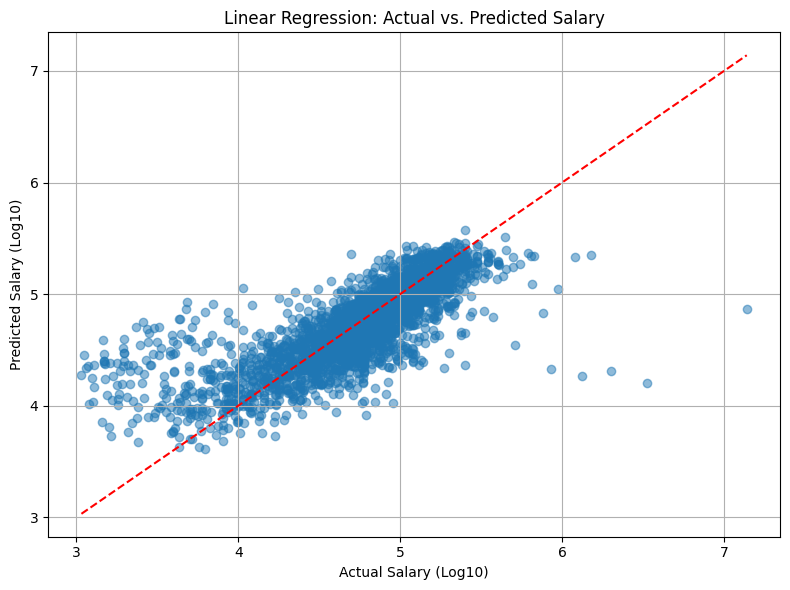

Saved Linear Regresson model to 'lr_model.pkl'


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import joblib

# ------------------------------------
# Initialize and fit the Linear Regression model
# ------------------------------------
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
lr_model.fit(X_train, y_train)

# Evaluate on training set
y_train_pred_lr = lr_model.predict(X_train)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2 = r2_score(y_train, y_train_pred_lr)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")

# ------------------------------------
# Make predictions
# ------------------------------------
y_pred_lr = lr_model.predict(X_test)

# ------------------------------------
# Evaluate model performance
# ------------------------------------
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression R²: {r2_lr:.4f}")

# ------------------------------------
# Plot Actual vs. Predicted
# ------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # identity line
plt.xlabel("Actual Salary (Log10)")
plt.ylabel("Predicted Salary (Log10)")
plt.title("Linear Regression: Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------
# Generate pkl file
# ------------------------------------
joblib.dump(lr_model, 'lr_model.pkl')
print("Saved Linear Regresson model to 'lr_model.pkl'")

# Ridge

Best alpha: 2.1544346900318843
Best R² on training data (CV): 0.6114478529405305
RidgeCV RMSE: 0.0810
RidgeCV R²: 0.6093


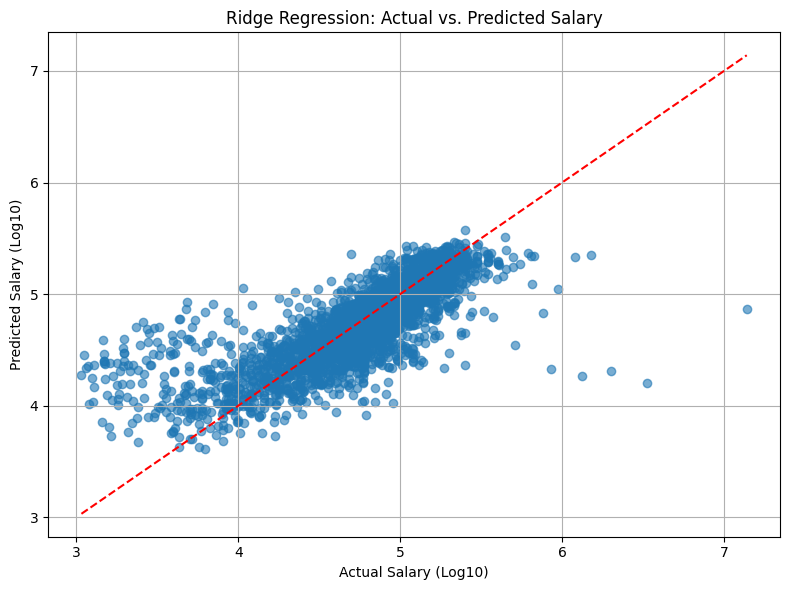

Saved Ridge model to 'ridge_model.pkl'


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------
# Ridge Regression with CV
# ------------------------------------
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# ------------------------------------
# Define parameter grid for alpha
# ------------------------------------
ridge_param_grid = {
    'ridge__alpha': np.logspace(-3, 2, 10),  # 0.001 to 100
    'ridge__solver': ['auto', 'cholesky'],
    'ridge__fit_intercept': [True, False]
}

#ridge_param_grid = [
#{
#    'ridge__solver': ['svd', 'cholesky'],
#    'ridge__alpha': np.logspace(-4, 3, 50),
#    'ridge__fit_intercept': [True, False]
#},
#{
#    'ridge__solver': ['saga', 'lsqr', 'auto'],
#    'ridge__alpha': np.logspace(-4, 3, 50),
#    'ridge__fit_intercept': [True, False],
#    'ridge__max_iter': [5000, 10000]
#}
#]
# ------------------------------------
# Set up GridSearchCV
# ------------------------------------
ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=10, scoring='r2')
ridge_grid.fit(X_train, y_train)

# ------------------------------------
# Best model
# ------------------------------------
print("Best alpha:", ridge_grid.best_params_['ridge__alpha'])
print("Best R² on training data (CV):", ridge_grid.best_score_)

# ------------------------------------
# Evaluate on test data
# ------------------------------------
y_pred_ridge = ridge_grid.predict(X_test)

rmse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"RidgeCV RMSE: {rmse_ridge:.4f}")
print(f"RidgeCV R²: {r2_ridge:.4f}")

# ------------------------------------
# Plot Ridge Results
# ------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (Log10)")
plt.ylabel("Predicted Salary (Log10)")
plt.title("Ridge Regression: Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------
# Save best Ridge model
# ------------------------------------
joblib.dump(ridge_grid.best_estimator_, 'ridge_model.pkl')
print("Saved Ridge model to 'ridge_model.pkl'")

# Lasso

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'lasso__alpha': np.float64(0.001112048883469199), 'lasso__fit_intercept': True, 'lasso__selection': 'random', 'lasso__tol': 0.0001}
Best R² on Training Data (CV): 0.6118995237357391
Lasso RMSE: 0.0806
Lasso R²: 0.6115


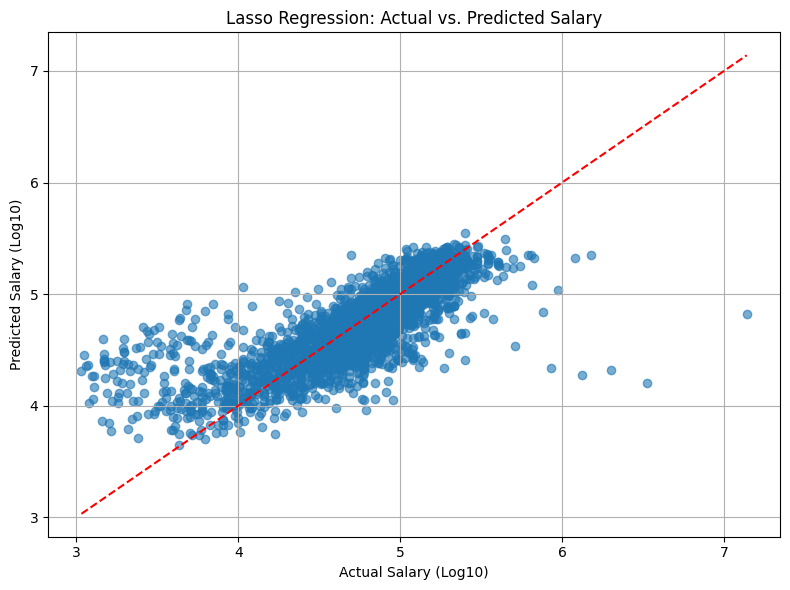

Saved Lasso model to 'lasso_model.pkl'


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import loguniform
import matplotlib.pyplot as plt
import joblib
import numpy as np

# ------------------------------------
# Lasso Regression with CV
# ------------------------------------
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=50000))
])

# ------------------------------------
# Define the alpha grid (regularization strength)
# ------------------------------------
lasso_param_dist = {
    'lasso__alpha': loguniform(1e-3, 3),         # continuous range: 0.001 to 3
    'lasso__fit_intercept': [True, False],
    'lasso__selection': ['cyclic', 'random'],
    'lasso__tol': [1e-3, 1e-4]                   # controls convergence strictness
}

# ------------------------------------
# Set up GridSearchCV
# ------------------------------------
#lasso_grid = GridSearchCV(lasso_pipeline, lasso_param_grid, cv=5, scoring='r2')
lasso_search = RandomizedSearchCV(
    estimator=lasso_pipeline,
    param_distributions=lasso_param_dist,
    n_iter=20,              # Try 20 random combinations
    cv=5,                   # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,              # Use all cores
    verbose=1,
    random_state=42
)

#lasso_grid.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)

# ------------------------------------
# Best parameters and score on training folds
# ------------------------------------
#print("Best alpha:", lasso_grid.best_params_['lasso__alpha'])
#print("Best R² on training data (CV):", lasso_grid.best_score_)
print("Best Parameters:", lasso_search.best_params_)
print("Best R² on Training Data (CV):", lasso_search.best_score_)

# ------------------------------------
# Evaluate on test set
# ------------------------------------
#y_pred_lasso = lasso_grid.predict(X_test)
y_pred_lasso = lasso_search.predict(X_test)

rmse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"LassoCV RMSE: {rmse_lasso:.4f}")
print(f"LassoCV  R²: {r2_lasso:.4f}")

# ------------------------------------
# Plot Lasso Results
# ------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (Log10)")
plt.ylabel("Predicted Salary (Log10)")
plt.title("Lasso Regression: Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------
# Save best Lasso model
# ------------------------------------
#joblib.dump(lasso_grid.best_estimator_, 'lasso_model.pkl')
joblib.dump(lasso_search.best_estimator_, 'lasso_model.pkl')
print("Saved Lasso model to 'lasso_model.pkl'")

# Random Forest

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Params: {'rf__bootstrap': True, 'rf__max_depth': 30, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 10, 'rf__n_estimators': 189}
Best R² on Training Data (CV): 0.6119614458645245
RandomizedSearchCV RF RMSE: 0.2831
RandomizedSearchCV RF R²: 0.6136


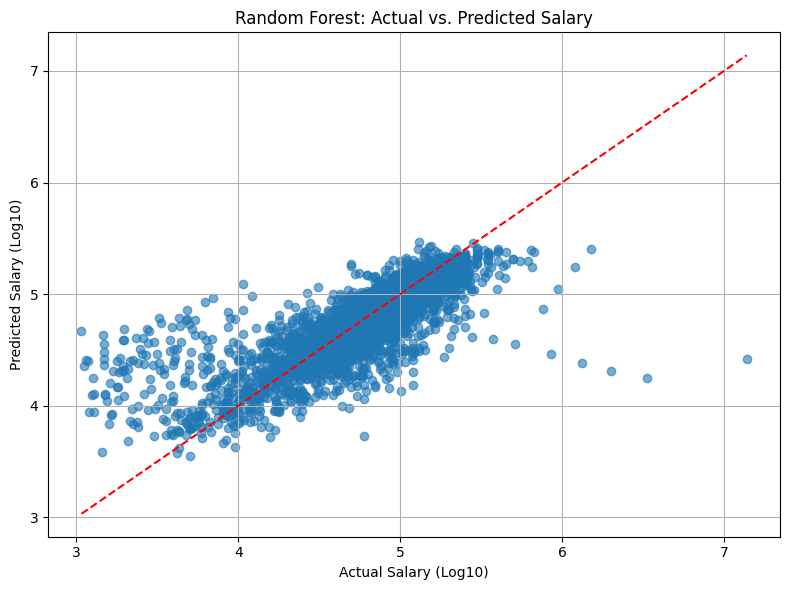

Saved Random Forest model to 'rf_model.pkl'


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import joblib
import numpy as np

# ------------------------------------
# Random Forest Pipeline (no scaling needed)
# ------------------------------------
rf_pipeline = Pipeline([
    ('rf', RandomForestRegressor(random_state=42))
])

# ------------------------------------
# Randomized Parameter Distributions
# ------------------------------------
rf_param_dist = {
    'rf__n_estimators': randint(100, 300),         # 100 to 299
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': randint(2, 11),       # 2 to 10
    'rf__min_samples_leaf': randint(1, 5),         # 1 to 4
    'rf__max_features': ['sqrt', 0.5],             # use sqrt or 50% of features
    'rf__bootstrap': [True, False]
}

# ------------------------------------
# RandomizedSearchCV Setup
# ------------------------------------
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=30,              # number of combinations to try
    cv=3,                   # 3-fold CV
    n_jobs=-1,              # parallelize
    scoring='r2',
    random_state=42,
    verbose=1
)

# ------------------------------------
# Fit Model
# ------------------------------------
rf_search.fit(X_train, y_train)

# ------------------------------------
# Best Parameters and CV Score
# ------------------------------------
print("Best Params:", rf_search.best_params_)
print("Best R² on Training Data (CV):", rf_search.best_score_)

# ------------------------------------
# Evaluate on Test Set
# ------------------------------------
y_pred_rf = rf_search.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"RandomizedSearchCV RF RMSE: {rmse_rf:.4f}")
print(f"RandomizedSearchCV RF R²: {r2_rf:.4f}")

# ------------------------------------
# Plot Results
# ------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (Log10)")
plt.ylabel("Predicted Salary (Log10)")
plt.title("Random Forest: Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------
# Save Best Model
# ------------------------------------
joblib.dump(rf_search.best_estimator_, 'rf_model.pkl')
print("Saved Random Forest model to 'rf_model.pkl'")


# XGB

Best Params: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best R² on training data (CV): 0.6212434974946913
XGB RMSE: 0.2798
XGB R²: 0.6224


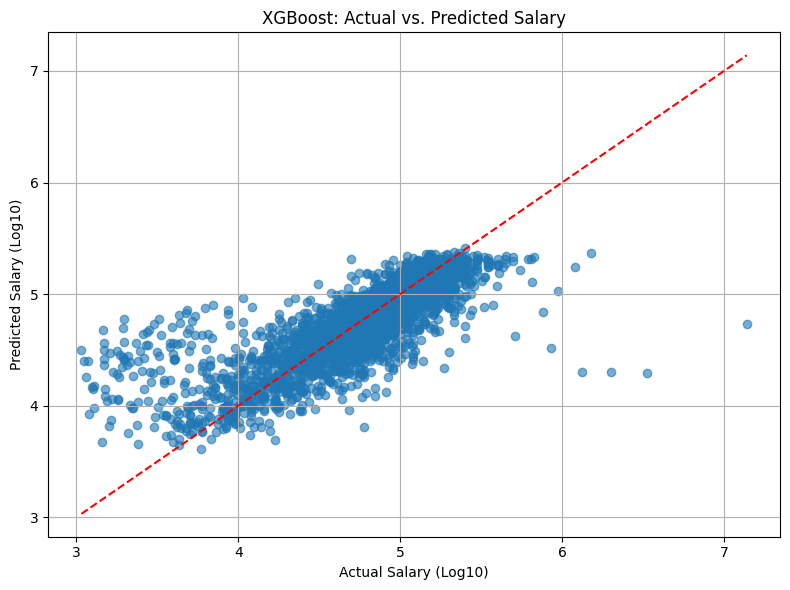

Saved XGBoost model with scaler to 'xgb_model.pkl'


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# ------------------------------------
# XGBoost Pipeline with Scaler
# ------------------------------------
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# ------------------------------------
# Parameter grid for XGB
# ------------------------------------
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.3]
}

# ------------------------------------
# GridSearchCV setup
# ------------------------------------
xgb_grid = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=3, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# ------------------------------------
# Best parameters and score
# ------------------------------------
print("Best Params:", xgb_grid.best_params_)
print("Best R² on training data (CV):", xgb_grid.best_score_)

# ------------------------------------
# Evaluate on Test Set
# ------------------------------------
y_pred_xgb = xgb_grid.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGB RMSE: {rmse_xgb:.4f}")
print(f"XGB R²: {r2_xgb:.4f}")

# ------------------------------------
# Plot predictions
# ------------------------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Salary (Log10)")
plt.ylabel("Predicted Salary (Log10)")
plt.title("XGBoost: Actual vs. Predicted Salary")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------
# Save model pipeline
# ------------------------------------
joblib.dump(xgb_grid.best_estimator_, 'xgb_model.pkl')
print("Saved XGBoost model with scaler to 'xgb_model.pkl'")